## Тема 2. Сглаживающая аппроксимация в полиномиальных базисах. 

In [1]:
%matplotlib inline

import numpy as np
import scipy.linalg as la
import scipy.interpolate as interp
import scipy.integrate as integrate
import matplotlib as mpl
import matplotlib.pyplot as plt
import sympy
import sklearn

default_dpi = mpl.rcParamsDefault['figure.dpi']
factor = 1
mpl.rcParams['figure.dpi'] = default_dpi * factor

### Функции вычисления коэффициентов разложения

In [6]:
# x(n), y(n) - массив данных
# m - степень полинома (количество базисных функций - 1)

def SqLeast (x, y, m):
    global G, Phi
    n = len(x)
    Phi = np.zeros ((n,m+1))
    for k in range (0, m+1):
        Phi[:,k] = BasicFunctions (k, x)
    PhiT = Phi.T
    G = PhiT @ Phi
    z = PhiT @ y
    a = np.linalg.solve(G, z)
    return a

def SqLeastReg (x, y, m, alpha):
    global G
    n = len(x)
    Phi = np.zeros ((n,m+1))
    for k in range (0, m+1):
        Phi[:,k] = BasicFunctions (k, x)
    PhiT = Phi.T
    
    RegAlpha = np.eye (m+1) * alpha
        
    G = PhiT @ Phi + RegAlpha 
    z = PhiT @ y
    a = np.linalg.solve(G, z)
    return a

def BasicFunctions (num, x):
    PhiFun = x**num
    return PhiFun

### Функция вычисления погрешности аппроксимации

In [7]:
def AppError (x,y,Coefs):
    
    PolynomValue = np.zeros(len(x))
    m = len(Coefs)-1
    for j in range (0, m+1):
        PolynomValue += Coefs[j]*x**j
    
    y_av = np.sum(y)/len(x) #average of y values
    y_disp = np.sum((y-y_av)**2)/len(x) #variance of y
    yv_disp = np.sum((PolynomValue-y_av)**2)/len(x) #variance of approximator
    
    ResLocal = (y - PolynomValue)#residual vector
    ResLocalRel = ResLocal/y_disp**0.5 #dimensionless residual vector
    
    ResGlobal = (np.sum ((ResLocal)**2)/len(x))**0.5
    ResGlobalRel = ResGlobal / y_disp**0.5
    
    MSE = (np.sum ((ResLocal)**2)/len(x)) # mean squared error
    SE = MSE**0.5 # standart error
    SErel = SE / y_disp**0.5 # relative standart error
    
    TSS = np.sum((y-y_av)**2) # total sum of squares 
    RSS = np.sum ((ResLocal)**2) #residual sum of squares
    RSE = (RSS/(len(x)-m))**0.5
    
    R2 = (TSS-RSS)/TSS
    R22 = yv_disp/y_disp     
         
    return ResLocal, SE, SErel, R2

### Формирование набора данных

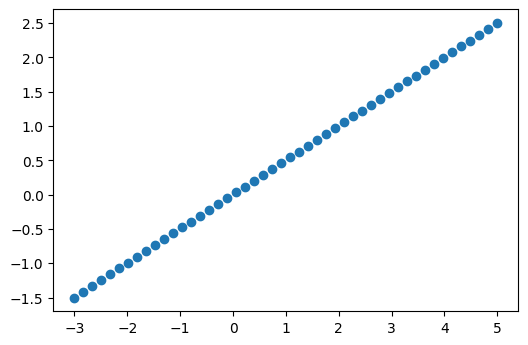

In [8]:
xleft = -3
xright = 5
n = 48
x = np.linspace(xleft,xright,n)
yf = np.zeros ((n))
y = np.zeros ((n))
#yf = np.sin(np.pi*x)
for i in range(0,n):
    if (x[i]<0) :
        yf[i] = 0.5*x[i] + 0.25*np.sin(2*x[i])
    elif (x[i]<np.pi):
        yf[i] = 0.5*x[i] + 0.5*np.sin(2*x[i])
    else:
        yf[i] = 0.5*x[i] + 0.75*np.sin(2*x[i])
yf = 0.5*x #-0.2*(x**2)+0.4*np.sin(2*x)
plt.plot (x,yf, 'o')

### Зашумление данных

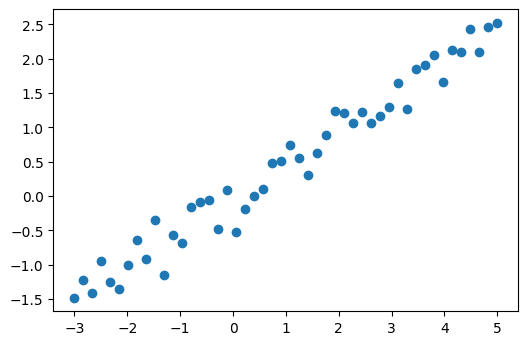

In [9]:
Delta = 0.25 * np.random.randn(len(x))
y = yf + Delta
plt.plot (x, y, 'o')

### Построение аппроксимационного полинома 

Коэффициенты [-7.77330262e-02  4.83552896e-01  1.97872328e-02 -1.16220587e-03
 -1.36461946e-03  1.04482623e-04  2.31776220e-05]
Число обусловленности 98517241.88605802 9925.5852162001
Максимальное и минимальное собственные значения G 715404113.3963532 7.261714798887553


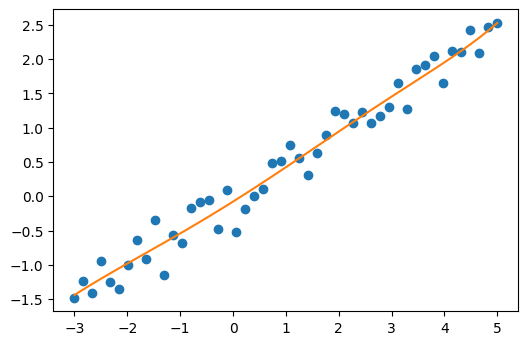

In [10]:
m = 6

PolynomCoefs = SqLeast (x, y, m)
print ('Коэффициенты', PolynomCoefs)

#print ('Gmatrix',G)
cond = np.linalg.cond (G)
condPhi = np.linalg.cond (Phi)
EigG = np.linalg.eigvals (G)
print ('Число обусловленности', cond, condPhi)
print ('Максимальное и минимальное собственные значения G', max (EigG), min (EigG))

PolynomValue = np.zeros(len(x))
for j in range (0, m+1):
    PolynomValue += PolynomCoefs[j]*x**j   

#ResLocal, ResLocalRel, ResGlobal, ResGlobalRel = AppError (x,y,PolynomCoefs)
#ResLocal, ResLocalRel, ResGlobal, ResGlobalRel, MSE, RSE, R2, R22 = AppError (x,y,PolynomCoefs)

plt.plot (x, y, 'o')
plt.plot (x, PolynomValue)

### Оценка погрешности аппроксимации

Погрешность аппроксимации
абсолютная, относительная, коэффициент детерминации
0.21524467922233007 0.18207879467667312 0.9668473125290898
0.9999999999999999


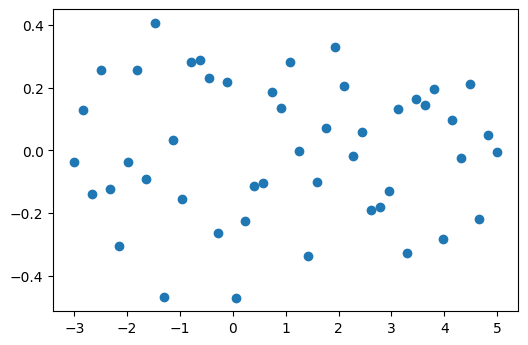

In [11]:
#ResLocal, ResLocalRel, ResGlobal, ResGlobalRel = AppError (x,y,PolynomCoefs)
#R2 = R2calc (x,y,PolynomCoefs)
ResLocal, SE, SErel, R2 = AppError (x,y,PolynomCoefs)
plt.plot (x, ResLocal, 'o')
print ('Погрешность аппроксимации')
print ('абсолютная, относительная, коэффициент детерминации')
print (SE, SErel, R2)
print (SErel**2+R2)

### Разделение данных на обучающий и тестовый наборы

[27 41  0 21  7 13 38 43 45 10 14  9]
SEtrain, SEtest 0.1891995424758038 0.3172277614643059
R2train, R2test 0.9738754586821434 0.9315505139654299


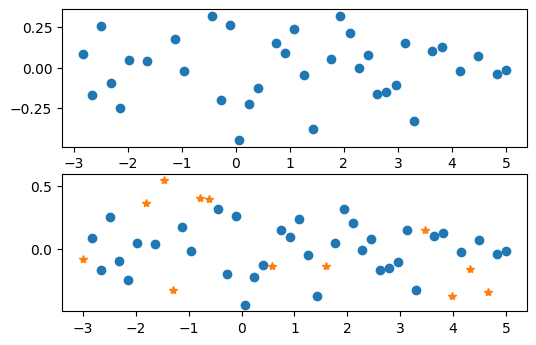

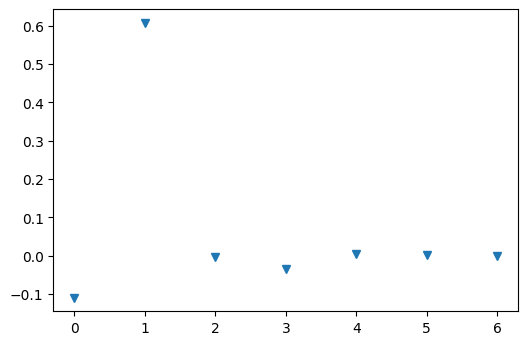

In [12]:
n = len(x)
ntest = int (n/4)
ntrain = n - ntest
xtrain = np.zeros (ntrain)
xtest = np.zeros (ntest)
ytrain = np.zeros (ntrain)
ytest = np.zeros (ntest)
#indtest = np.random.random_integers(0,n, ntest)
indtest = np.random.choice (len(x), ntest, replace = False)
print (indtest)

itest = -1
itrain = -1
for i in range (0,n):
    
    ktest = 0
    
    for k in range (0, ntest): 
        if (i==indtest[k]):
            itest += 1
            xtest [itest] = x[i]
            ytest [itest] = y[i]
            ktest = 1
            
    if (ktest !=1 ):
        itrain += 1
        xtrain [itrain] = x[i]
        ytrain [itrain] = y[i]
             
#print (xtest)
#print (xtrain)

PolynomCoefsTrain = SqLeast (xtrain, ytrain, m)
    
ResLocalTrain, SETrain, SErelTrain, R2Train = AppError (xtrain,ytrain,PolynomCoefsTrain)
ResLocalTest, SETest, SErelTest, R2Test = AppError (xtest,ytest,PolynomCoefsTrain)    
    
print ('SEtrain, SEtest', SETrain, SETest)
print ('R2train, R2test', R2Train, R2Test)
#print (R2Train+SErelTrain**2, R2Test+SErelTest**2)
 
plt.subplot (2,1,1)
plt.plot (xtrain, ResLocalTrain, 'o')
plt.subplot (2,1,2)
plt.plot (xtrain, ResLocalTrain, 'o')
plt.plot (xtest, ResLocalTest, '*')
plt.figure ()
plt.plot (PolynomCoefsTrain, 'v')

### Использование scikit-learn

0.9882404415515014
0.9261269092745555


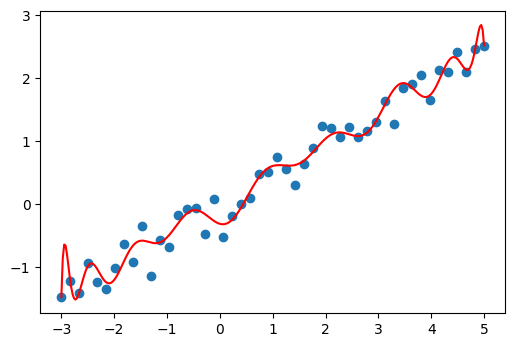

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
X2 = np.zeros ((len(x),1))
X2[:,0]=x

X_train, X_test, y_train, y_test =  train_test_split(X2,y, random_state=0)

degree=20

polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
pl=polyreg.fit(X_train,y_train)

pl.score(X_train,y_train)
pl.score(X_test,y_test)
X_seq = np.linspace(X2.min(),X2.max(),300).reshape(-1,1)
plt.figure()
plt.scatter(X2,y)
plt.plot(X_seq,polyreg.predict(X_seq),color="red")

print (pl.score(X_train,y_train))
print (pl.score(X_test,y_test))

(379, 13)
[-1.28322638e-01  2.95517751e-02  4.88590934e-02  2.77350326e+00
 -1.62388292e+01  4.36875476e+00 -9.24808158e-03 -1.40086668e+00
  2.57761243e-01 -9.95694820e-03 -9.23122944e-01  1.31854199e-02
 -5.17639519e-01]
0.748087259862344
0.6844267283527068


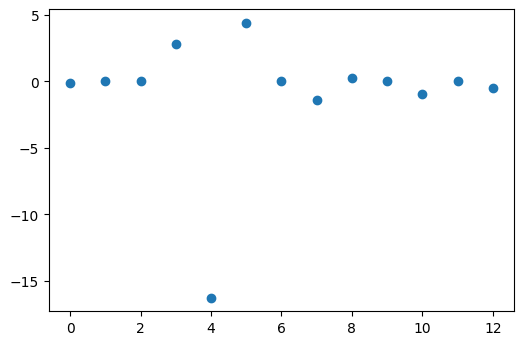

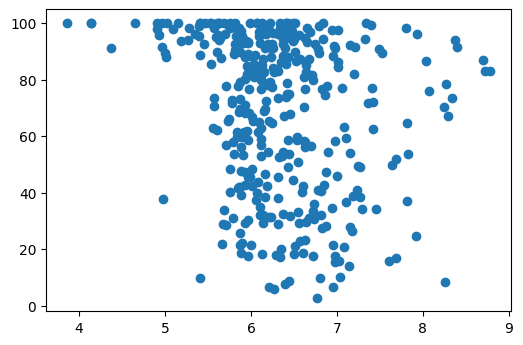

In [14]:
from sklearn.datasets import load_boston
boston = load_boston()
XB = boston.data
yB = boston.target
X_train, X_test, y_train, y_test =  train_test_split(XB,yB, random_state=42)
print ("{}".format(X_train.shape))
lr=LinearRegression().fit(X_train, y_train)
print ("{}".format(lr.coef_))
lr.score(X_train,y_train)
lr.score(X_test,y_test)
print (lr.score(X_train,y_train))
print (lr.score(X_test,y_test))
plt.plot(lr.coef_, 'o')
plt.figure()
plt.scatter(X_train[:,5],X_train[:,6])

### Проблема обусловленности

In [15]:
n = 6
# Формирование матрицы Гильберта
MM = np.zeros ((n,n))
for i in range (0,n):
    for j in range (0,n):
        MM[i,j]=1/(i+j+1) #*10.
print (MM)
# Нахождение собственных значений матрицы
Evv = np.linalg.eigvals (MM)
print ('Eigen values', Evv)
# Формирование правой части
b = np.linspace (1,5,n)/n
print ('b',b)
# Нахождение решения системы уравнений
xx = np.linalg.solve(MM, b)
print ('solution',xx)
# Вычиление невязки
res = MM @ xx - b
print ('Residual', res)

MMinv = np.linalg.inv(MM)
normb = np.linalg.norm (b)
normM = np.linalg.norm (MM)
normMi = np.linalg.norm (MMinv)
normx = np.linalg.norm (xx)

#число обусловленности
cond = np.linalg.cond (MM)
print ('cond', cond, normM * normMi, max(Evv)/min(Evv))

#возмущение правой части
Del = (np.random.random(n)- 0.5) * 0.01
normDel = np.linalg.norm (Del)
b2 = b + Del
# Решение возмущенной системы
xx2 = np.linalg.solve(MM, b2)
print ('b', b2, )
print ('solution', xx2)
dx = xx-xx2
normdx = np.linalg.norm (dx)
res = MM @ xx2 - b2
print ('residual', res)

[[1.         0.5        0.33333333 0.25       0.2        0.16666667]
 [0.5        0.33333333 0.25       0.2        0.16666667 0.14285714]
 [0.33333333 0.25       0.2        0.16666667 0.14285714 0.125     ]
 [0.25       0.2        0.16666667 0.14285714 0.125      0.11111111]
 [0.2        0.16666667 0.14285714 0.125      0.11111111 0.1       ]
 [0.16666667 0.14285714 0.125      0.11111111 0.1        0.09090909]]
Eigen values [1.61889986e+00 2.42360871e-01 1.63215213e-02 6.15748354e-04
 1.25707571e-05 1.08279948e-07]
b [0.16666667 0.3        0.43333333 0.56666667 0.7        0.83333333]
solution [   -29.00000001    987.00000016  -7672.00000112  22344.00000293
 -27090.00000324  11550.00000128]
Residual [-1.51573198e-13 -1.18233201e-12 -3.94129174e-13  3.94018151e-13
 -4.09339229e-13 -5.30575583e-13]
cond 14951058.642254665 15118987.12835571 14951058.641395982
b [0.1653085  0.3028641  0.43164975 0.56626098 0.70242483 0.83268588]
solution [-1.33166986e+01  5.04057803e+02 -4.26378831e+03  1.3

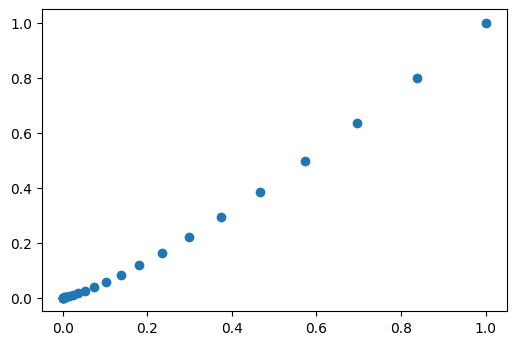

In [16]:
xleft = 0
xright = 1
n = 24
x1 = np.linspace(xleft,xright,n)
y1 = np.zeros ((n))
y2 = np.zeros ((n))
y1 = x1**4 
y2 = x1**5
plt.plot (y1,y2, 'o')

## Пример 3

Коэффициенты точные [-1.   1.   2.   1.  -1.  -0.5]
Коэффициенты МНК [-1.08855553  1.23737501  1.95698583  0.90074274 -0.98733382 -0.4896296 ]
12373162.972719174
Коэффициенты МНК с регуляризацией [-1.10123429  1.38894792  1.79187144  0.72585461 -0.72298758 -0.56716316]
369807.63413101755
s [6.17413874e+01 6.54357569e+00 2.56943786e+00 7.10994096e-01
 1.39866108e-01 1.75523802e-02]


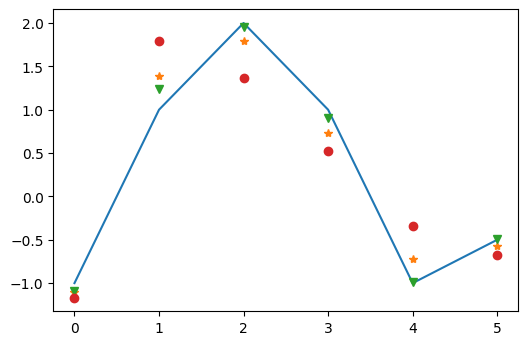

In [17]:
xleft = 0.0
xright = 2.0
n = 24
x_array = np.linspace(xleft,xright,n)
yf_array = np.zeros ((n))
y_array = np.zeros ((n))

coefs = np.array ([-1, 1, 2, 1,-1,-0.5])
m = len(coefs)- 1

print ('Коэффициенты точные', coefs)

for i in range (0, m+1):
    yf_array += coefs[i]*x_array**i
#plt.plot (x,yf, 'o')

Delta = 0.1 * np.random.randn(len(x_array))
y_array = yf_array + Delta
#plt.plot (x, y, '*')

PolynomCoefs = SqLeast (x_array, y_array, m)
print ('Коэффициенты МНК', PolynomCoefs)

#print ('Gmatrix',G)
cond = np.linalg.cond (G)
print (cond)

PolynomValue = np.zeros(len(x_array))
for i in range (0, m+1):
    PolynomValue += PolynomCoefs[i]*x_array**i
        
#plt.plot (x, y, 'o')
#plt.plot (x, PolynomValue)
#plt.subplot (x, ErrorLocal)

CoefsReg = SqLeastReg (x_array, y_array, m, 0.01)
print ('Коэффициенты МНК с регуляризацией', CoefsReg)
cond = np.linalg.cond (G)
print (cond)

PolynomValue = np.zeros(len(x_array))
for i in range (0, m+1):
    PolynomValue += CoefsReg[i]*x_array**i
#plt.plot (x, PolynomValue)

PhiInv = np.linalg.pinv(Phi, rcond = 1e-2)
CoefsSVD = PhiInv @ y_array
#print ('коэффициенты МНК SVD', CoefsSVD )

U, s, Vh = np.linalg.svd(Phi)
print ('s', s)
#smat = np.diag(s)

#plt.subplot (2,1,1)
plt.plot (coefs)
plt.plot (CoefsReg, '*')
plt.plot (PolynomCoefs, 'v')
plt.plot (CoefsSVD, 'o')
#plt.plot (coef2, '-')
#plt.subplot (2,1,2)
#plt.plot (coefs)
#plt.plot (coef2)